*Aprenentatge Computacional*  
- Zakaria Boudich Makran (1672001)

# Pràctica - Google Play Store Apps

En aquesta pràctica s'abordarà la creació d'un model per tal de predir el nombre de descàrregues que tindrà una aplicació mòbil, representat per l'atribut *installs*. Seguirem una sèrie de passos per obtenir el resultat, primer analitzarem les dades, les preprocessarem, s'escollirà les mètriques i els diferents models per així aconseguir el millor classificador.

## 0. Importació de llibreries 

Importem les llibreries necessàries per a la manipulació, visualització i anàlisi de dades ⚙️

In [2]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
from category_encoders.one_hot import OneHotEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

## 1. EDA (exploratory data analysis) 

En aquest apartat, realitzarem una anàlisi exploratòria de les dades, on examinarem les característiques del conjunt de dades, buscarem patrons i visualitzarem la distribució de les variables. 

En aquest cas, ens ve donat **dos conjunts de dades**. L'objectiu serà unir-los per aprofitar els atributs més rellevants de cadascun i utilitzar-los en l'entrenament del model. Ara farem una breu descripció de cada conjunt de dades:

**1. Dataset de les aplicacions (Apps):** 📲  
* Conté informació sobre les aplicacions a la Google Play Store, com el nom, la categoria, la valoració mitjana, el nombre d'instal·lacions, el preu, etc.  
* Aquest conjunt de dades ens permet entendre les característiques bàsiques de cada aplicació i el seu rendiment a la botiga.

**2. Dataset de les ressenyes (Reviews):** ⭐ 
* Conté les opinions dels usuaris sobre les aplicacions anteriors. Cada ressenya inclou la valoració que l'usuari ha donat a l'aplicació, el text de la ressenya, etc. 
* Aquest conjunt de dades és útil per estudiar el sentiment dels usuaris i com les valoracions individuals poden influir en la valoració general de l'aplicació.

**Per simplicitat**, primer tractarem el dataset d'aplicacions i després el de les ressenyes.


### 1.1. Anàlisis del dataset de les aplicacions

#### 1.1.1. Descripció dels atributs


In [3]:
apps_data = pd.read_csv("data/aplicacions.csv")
apps_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
print("El nombre de mostres que tenim a la base de dades és de", apps_data.shape[0])
print("El nombre de atributs que tenim a la base de dades és de", apps_data.shape[1])

El nombre de mostres que tenim a la base de dades és de 10841
El nombre de atributs que tenim a la base de dades és de 13


Es pot veure que disposem de 13 atributs diferents amb un total de 10841 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del nombre de descàrregues d'una aplicació.


In [5]:
print("Informació de cada atribut:")
print(apps_data.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None


La base de dades conté 13 atributs on es descriu les característiques de cada aplicació. A continuació es fa una breu descripció de cada *feature*:

- **App (Objecte):** Nom de l'aplicació.  
- **Category (Objecte):** Categoria de l'aplicació.  
- **Rating (Float64):** Valoració de l'aplicació (valor de 1 a 5).  
- **Reviews (Int64):** Nombre de ressenyes que té l'aplicació.  
- **Size (Objecte):** Mida de l'aplicació en megabytes. (Pot incloure unitats com 'M' o 'k')  
- **Installs (Objecte):** Nombre d'instal·lacions de l'aplicació. Pot contenir caràcters com '+' o ',' que caldrà netejar.  
- **Type (Objecte):** Si l'aplicació és gratuïta o de pagament.  
- **Price (Objecte):** El preu de l'aplicació (si és de pagament). Pot incloure un símbol '$' que s'ha de netejar per convertir-lo en numèric.  
- **Content Rating (Objecte):** Classificació per contingut (per exemple, "Tots els públics", "Adolescents", etc.).  
- **Genres (Objecte):** Gèneres de l'aplicació (com "Acció", "Educació", etc.).  
- **Last Updated (Objecte):** Data de l'última actualització de l'aplicació.  
- **Current Ver (Objecte):** Versió actual de l'aplicació.  
- **Android Ver (Objecte):** Versió d'Android compatible amb l'aplicació.

**Nota 📝**\
A l'hora de descriure el tipus de dades dels atributs pels dos datasets, utilitzem el tipus assignat per Pandas (com objecte, enter o flotant). Tot i així, considerem certs atributs de tipus object com a valors de tipus numèric a causa de la seva naturaleza. En aquest cas son els següents: *Rating*, *Reviews*, *Size*, *Installs* i *Price*. Més endavant, aplicarem un procés d'escapament per eliminar caràcters que no ens aporten informació dels atributs esmentats i transformar-los a tipus numèric. 

#### 1.1.2. Detecció de valors nuls

A continuació mostrarem el nombre de NaNs per cada atribut:


In [6]:
print(apps_data.isnull().sum())

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


Podem observar la aparició de valors NaNs en els atributs següents: *Rating*, *Current Ver*, *Android Ver*, *Type* i *Content Rating*. D'aquests atributs el més significatiu és el *Rating*, obtenint un percentatge de NaNs proper el 15%.

### 1.2. Anàlisis del dataset de les ressenyes

#### 1.1.1. Descripció dels atributs

In [10]:
reviews_data = pd.read_csv("data/ressenyes.csv")
apps_data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [11]:
print("El nombre de mostres que tenim a la base de dades és de", reviews_data.shape[0])
print("El nombre de atributs que tenim a la base de dades és de", reviews_data.shape[1])

El nombre de mostres que tenim a la base de dades és de 64295
El nombre de atributs que tenim a la base de dades és de 5


Es pot veure que disposem de 5 atributs diferents amb un total de 64295 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del nombre de descàrregues d'una aplicació.


In [12]:
print("Informació de cada atribut:")
print(reviews_data.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB
None


El conjunt de dades conté 5 atributs on es descriu les característiques de reviews de cada aplicació. A continuació es fa una breu descripció de cada *feature*:

- **App (Objecte):** Nom de l'aplicació a la qual pertany la ressenya. Ens serveix com enllaç del dataset anterior. 
- **Translated_Review (Objecte):** Text de la ressenya traduït a l'anglès. Pot contenir valors nuls si no hi ha ressenya.  
- **Sentiment (Objecte):** Categoria del sentiment expressat a la ressenya (per exemple, "Positiu", "Negatiu" o "Neutral").  
- **Sentiment_Polarity (Float64):** Mesura de polaritat del sentiment de la ressenya, amb valors entre -1 (molt negatiu) i 1 (molt positiu).  
- **Sentiment_Subjectivity (Float64):** Mesura de subjectivitat de la ressenya, amb valors entre 0 (totalment objectiu) i 1 (totalment subjectiu). 

#### 1.1.2. Detecció de valors nuls

Segons la sortida anterior podem veura una gran quantitat de valors nuls en les característiques, excepte l'atribut *App*. Anem a veure la distribució per cada atribut:

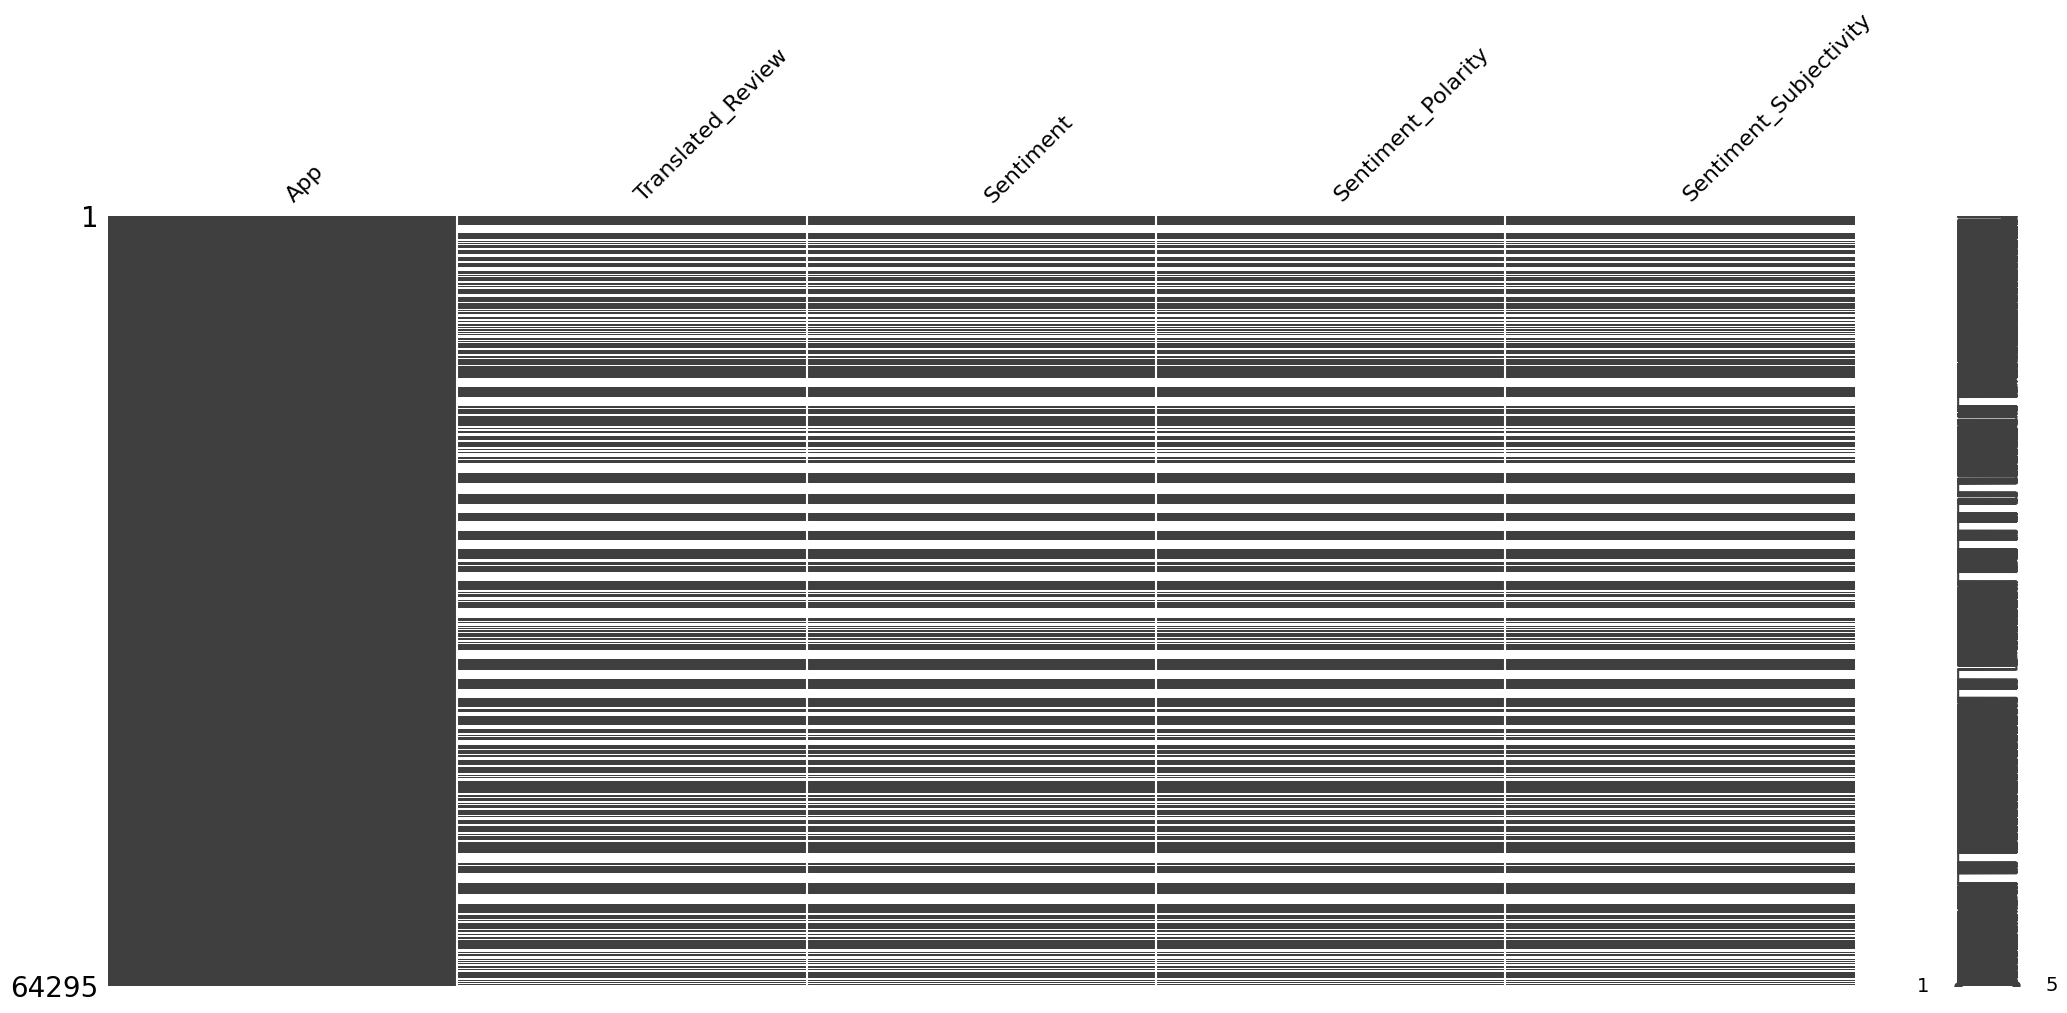

In [33]:
msno.matrix(reviews_data)
plt.show()

Com era d'esperar, hi ha una forta dependència entre els atributs *Translated_Review*, *Sentiment*, *Sentiment_Polarity* i *Sentiment_Subjectivity* pel que fa als valors nuls. La causa de tot això és l'atribut *Translated_Review*, ja que l'ànalisi del sentiment requereix que l'usuari hagi escrit un text per a la seva ressenya. 

#### 1.1.3. Detecció de dades anomals

A continuació comprovarem que els atributs no tinguin valors anòmals (*outliers*) que no hàgim detectat a primera vista. Els resultats els tindrem en compte pel *preprocessing* dels atributs. Començarem verificant els atributs categòrics, i posteriorment passarem als numèrics.  

**1. Atributs categòrics: 🏷️** 

- **App:** Comprovarem que tot nom d'aplicació del dataset *reviews* estigui present en el conjunt de dades *apps*. Si trobem que algun nom no es compleix, haurem d'analitzar com resoldre-ho, ja que més endavant necessitarem enllaçar els dos conjunts de dades per entrenar el model. 

In [52]:
missing_apps = reviews_data[~reviews_data['App'].isin(apps_data['App'])]
print(missing_apps)

Empty DataFrame
Columns: [App, Translated_Review, Sentiment, Sentiment_Polarity, Sentiment_Subjectivity]
Index: []


Segons el resultat anterior, podem veure que tots els noms d'aplicacions en el dataset *reviews* estan presents en el dataset *apps*


- **Sentiment:** Verificarem que no tinguem una categoria anomala, o una categoria que no s'hagi contemplat a primera vista.

In [54]:
sentiment_counts = reviews_data['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
Positive    23998
Negative     8271
Neutral      5163
Name: count, dtype: int64


En aquest cas tenim les categories Positive, Negative i Neutral. No s'observa ningun cas extrany. 

**1. Atributs numèrics: 🏷️** 
- **Sentiment_Polarity, Sentiment_Subjectivity:** Verificarem que no tinguem presents valors fora de rang dels respectius atributs. 

In [55]:
polarity_summary = reviews_data['Sentiment_Polarity'].describe()
subjectivity_summary = reviews_data['Sentiment_Subjectivity'].describe()

print(f"Sentiment_Polarity - Min: {polarity_summary['min']}, Max: {polarity_summary['max']}")
print(f"Sentiment_Subjectivity - Min: {subjectivity_summary['min']}, Max: {subjectivity_summary['max']}")

Sentiment_Polarity - Min: -1.0, Max: 1.0
Sentiment_Subjectivity - Min: 0.0, Max: 1.0


Podem comprovar pels dos atributs, que no ens apareix ningun valor fora del rang que hem detectat a primera vista en la descripció dels atributs.